#  Hybrid Search with Pinecone BM25Encoder

- Hybrid search combines semantic and keyword search in one query for more relevant results
- In Pinecone, we can perform hybrid search with sparse-dense vectors. 
- Sparse-dense vectors combine dense and sparse embeddings as a single vector. 
- Sparse and dense vectors represent different types of information and enable distinct kinds of search.


### Dense vectors
Dense vectors enable semantic search. 
Semantic search returns the most similar results according to a specific distance metric even if no exact matches are present. 
This is possible because dense vectors generated by embedding models such as SBERT are numerical representations of semantic meaning.

​
### Sparse vectors
Sparse vectors have very large number of dimensions, where only a small proportion of values are non-zero. 
When used for keywords search, each sparse vector represents a document;
the dimensions represent words from a dictionary, and the values represent the importance of these words in the document. 
Keyword search algorithms like the BM25 algorithm compute the relevance of text documents based on the number of keyword matches, their frequency, and other factors.

In [ ]:
import warnings
warnings.filterwarnings('ignore')

In [13]:
from datasets import load_dataset
from pinecone_text.sparse import BM25Encoder
from pinecone import Pinecone, ServerlessSpec
import os
import sys
from dotenv import load_dotenv, find_dotenv
from sentence_transformers import SentenceTransformer
from tqdm.auto import tqdm
import torch
import os

In [14]:
def get_pinecone_api_key():
  _ = load_dotenv(find_dotenv())
  return os.getenv("PINECONE_API_KEY")


In [15]:
PINECONE_API_KEY = get_pinecone_api_key()

In [16]:
pinecone = Pinecone(api_key=PINECONE_API_KEY)

# Creating Index in Pinecone

In [61]:
INDEX_NAME = 'sparsdense'

if INDEX_NAME in [index.name for index in pinecone.list_indexes()]:
  pinecone.delete_index(INDEX_NAME)
pinecone.create_index(
  INDEX_NAME,
  dimension=512,
  metric="dotproduct",
  spec=ServerlessSpec(cloud='aws', region='us-east-1')
)
index = pinecone.Index(INDEX_NAME)

In [62]:
index

# Loading fashion dataset

In [38]:
fashion = load_dataset(
    "ashraq/fashion-product-images-small",
    split="train[:1000]"
)
fashion

Dataset({
    features: ['id', 'gender', 'masterCategory', 'subCategory', 'articleType', 'baseColour', 'season', 'year', 'usage', 'productDisplayName', 'image'],
    num_rows: 1000
})

In [39]:
fashion.shape

(1000, 11)

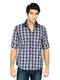

In [40]:
images = fashion['image']
metadata = fashion.remove_columns('image')
images[0]

In [41]:
metadata = metadata.to_pandas()
metadata.head()

,id,gender,masterCategory,subCategory,articleType,baseColour,season,year,usage,productDisplayName
0,15970,Men,Apparel,Topwear,Shirts,Navy Blue,Fall,2011.0,Casual,Turtle Check Men Navy Blue Shirt
1,39386,Men,Apparel,Bottomwear,Jeans,Blue,Summer,2012.0,Casual,Peter England Men Party Blue Jeans
2,59263,Women,Accessories,Watches,Watches,Silver,Winter,2016.0,Casual,Titan Women Silver Watch
3,21379,Men,Apparel,Bottomwear,Track Pants,Black,Fall,2011.0,Casual,Manchester United Men Solid Black Track Pants
4,53759,Men,Apparel,Topwear,Tshirts,Grey,Summer,2012.0,Casual,Puma Men Grey T-shirt


In [42]:
metadata.tail()

,id,gender,masterCategory,subCategory,articleType,baseColour,season,year,usage,productDisplayName
995,51232,Women,Apparel,Topwear,Kurtas,Green,Fall,2012.0,Ethnic,Satya Paul Women Green Printed Kaftan
996,17427,Men,Accessories,Watches,Watches,White,Winter,2016.0,Casual,CASIO G-Shock Men White Analogue & Digital Wat...
997,9804,Men,Apparel,Topwear,Shirts,Black,Fall,2011.0,Formal,John Miller Men Black Checks Shirts
998,23612,Women,Personal Care,Fragrance,Perfume and Body Mist,Pink,Spring,2017.0,Casual,Nike Fragrances Women Sensual Touch Perfume
999,6070,Women,Apparel,Topwear,Tshirts,Blue,Summer,2011.0,Casual,UCB Women's Young Pigment Blue T-shirt


In [46]:
metadata['subCategory'].value_counts()

subCategory
Topwear                     331
Shoes                       165
Bags                         74
Watches                      73
Bottomwear                   56
Innerwear                    42
Fragrance                    33
Flip Flops                   29
Sandal                       28
Jewellery                    27
Belts                        25
Wallets                      19
Eyewear                      17
Lips                         13
Loungewear and Nightwear     10
Headwear                     10
Dress                         9
Socks                         8
Saree                         6
Mufflers                      4
Scarves                       3
Apparel Set                   3
Makeup                        3
Free Gifts                    3
Accessories                   3
Shoe Accessories              2
Ties                          2
Skin Care                     1
Nails                         1
Name: count, dtype: int64

## Creating the sparse vector using BM25


In [47]:
# Crate the sparse vector using BM25

bm25 = BM25Encoder()
bm25.fit(metadata['productDisplayName'])
metadata['productDisplayName'][0]

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Alok\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping tokenizers\punkt.zip.
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Alok\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\stopwords.zip.
100%|██████████| 1000/1000 [00:00<00:00, 1433.21it/s]


'Turtle Check Men Navy Blue Shirt'

In [48]:
bm25.encode_queries(metadata['productDisplayName'][0])

{'indices': [23789636,
  1830646559,
  632192512,
  931643408,
  3905155331,
  3828986392],
 'values': [0.2988517448930939,
  0.2071291751626531,
  0.0406534126121921,
  0.18471582470004494,
  0.1160801094043974,
  0.15256973322761846]}

In [49]:
bm25.encode_documents(metadata['productDisplayName'][0])

{'indices': [23789636,
  1830646559,
  632192512,
  931643408,
  3905155331,
  3828986392],
 'values': [0.4474467030242935,
  0.4474467030242935,
  0.4474467030242935,
  0.4474467030242935,
  0.4474467030242935,
  0.4474467030242935]}

## Loading image embedding model clip-ViT-B-32

In [50]:
# create dense vector using clip
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = SentenceTransformer('sentence-transformers/clip-ViT-B-32', 
    device=device)
model
dense_vec = model.encode([metadata['productDisplayName'][0]])
dense_vec.shape

d:\NLP_Project\Gen_AI\venv\lib\site-packages\huggingface_hub\file_download.py:157: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\Alok\.cache\huggingface\hub\models--sentence-transformers--clip-ViT-B-32. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to see activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


(1, 512)

In [51]:
dense_vec

array([[ 3.47598732e-01,  1.86053470e-01, -3.43701839e-02,
        -8.76949579e-02,  2.12450922e-01, -4.63767439e-01,
        -2.62030244e-01, -2.67075419e-01,  2.11454839e-01,
        -1.45174697e-01, -2.21526489e-01,  7.72616506e-01,
         4.07887906e-01,  1.98980868e-01, -2.40782455e-01,
         1.00482270e-01,  3.12819600e-01,  2.33211905e-01,
         2.81544834e-01,  3.93811971e-01,  1.04463413e-01,
         2.52277404e-02,  2.92444348e-01, -2.01948255e-01,
         1.52713269e-01, -2.10447341e-01,  6.16782904e-02,
        -1.53535187e-01,  6.78101033e-02, -5.04500806e-01,
         2.05988139e-02,  2.61264712e-01,  2.34380037e-01,
        -9.56328735e-02, -3.77705097e-02, -2.17029825e-02,
        -1.11794040e-01,  2.48099715e-01, -1.26485378e-01,
        -1.26278803e-01, -1.43248707e-01, -3.04491073e-01,
        -3.61693382e-01, -1.24217212e-01, -2.30936050e-01,
         1.33256942e-01, -1.69667393e-01, -1.21024154e-01,
         9.53745544e-02,  1.76042646e-01, -2.91511774e-0

In [52]:
fashion.shape

(1000, 11)

## Creating Dense Vectors of Images and Sparse Vectors for text of each rows and concatinate all meta data in a single string for each rows

In [65]:
batch_size = 100
fashion_data_num = 1000

for i in tqdm(range(0, min(fashion_data_num,len(fashion)), batch_size)):
    # find end of batch
    i_end = min(i+batch_size, len(fashion))
    # extract metadata batch
    meta_batch = metadata.iloc[i:i_end]
    meta_dict = meta_batch.to_dict(orient="records")
    # concatinate all metadata field except for id and year to form a single string
    meta_batch = [" ".join(x) for x in meta_batch.loc[:, ~meta_batch.columns.isin(['id', 'year'])].values.tolist()]
    # extract image batch
    img_batch = images[i:i_end]
    # create sparse BM25 vectors
    sparse_embeds = bm25.encode_documents([text for text in meta_batch])
    # create dense vectors
    dense_embeds = model.encode(img_batch).tolist()
    # create unique IDs
    ids = [str(x) for x in range(i, i_end)]

    upserts = []
    # loop through the data and create dictionaries for uploading documents to pinecone index
    for _id, sparse, dense, meta in zip(ids, sparse_embeds, dense_embeds, meta_dict):
        upserts.append({
            'id': _id,
            'sparse_values': sparse,
            'values': dense,
            'metadata': meta
        })
    # upload the documents to the new hybrid index
    index.upsert(upserts)

# show index description after uploading the documents
index.describe_index_stats()

  0%|          | 0/10 [00:00<?, ?it/s]

100%|██████████| 10/10 [04:58<00:00, 29.86s/it]


{'dimension': 512,
 'index_fullness': 0.0,
 'namespaces': {'': {'vector_count': 1000}},
 'total_vector_count': 1000}

## Retrive image data with the help of Combination Of Dense and Sparse vectors

In [66]:
### Run Your Query

query = "dark blue french connection jeans for men"

sparse = bm25.encode_queries(query)
dense = model.encode(query).tolist()

result = index.query(
    top_k=14,
    vector=dense,
    sparse_vector=sparse,
    include_metadata=True
)

imgs = [images[int(r["id"])] for r in result["matches"]]
imgs

[<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=60x80>,
 <PIL.Image.Image image mode=RGB size=60x80>,
 <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=60x80>,
 <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=60x80>,
 <PIL.Image.Image image mode=RGB size=60x80>,
 <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=60x80>,
 <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=60x80>,
 <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=60x80>,
 <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=60x80>,
 <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=60x80>,
 <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=60x80>,
 <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=60x80>,
 <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=60x80>,
 <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=60x80>]

In [55]:
from IPython.core.display import HTML
from io import BytesIO
from base64 import b64encode

# function to display product images
def display_result(image_batch):
    figures = []
    for img in image_batch:
        b = BytesIO()
        img.save(b, format='png')
        figures.append(f'''
            <figure style="margin: 5px !important;">
              <img src="data:image/png;base64,{b64encode(b.getvalue()).decode('utf-8')}" style="width: 90px; height: 120px" >
            </figure>
        ''')
    return HTML(data=f'''
        <div style="display: flex; flex-flow: row wrap; text-align: center;">
        {''.join(figures)}
        </div>
    ''')


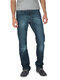
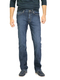
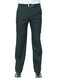
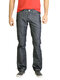
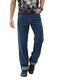
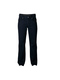
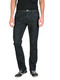
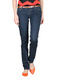
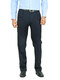
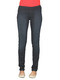
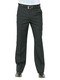
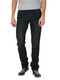
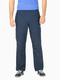
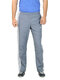

In [67]:
display_result(imgs)

# How To Scale Hybrrid Vector Search By Using a Convex Combination\

###  alpha * dense + (1 - alpha) * sparse
###  dense: Array of floats representing
###  sparse: a dict of `indices` and `values`
###  alpha: float between 0 and 1 where 0 == sparse only and 1 == dense only

In [68]:
def hybrid_scale(dense, sparse, alpha: float):
    
    if alpha < 0 or alpha > 1:
        raise ValueError("Alpha must be between 0 and 1")
    
    hsparse = {
        'indices': sparse['indices'],
        'values':  [v * (1 - alpha) for v in sparse['values']]
    }
    hdense = [v * alpha for v in dense]
    return hdense, hsparse

# 1. Using More Dense Value
### Closer to 0==more sparse, closer to 1==more dense


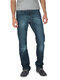
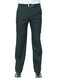
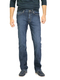
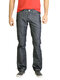
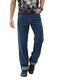
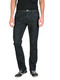
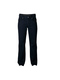
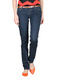
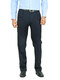
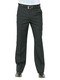
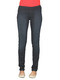
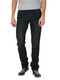

In [80]:
question = "dark blue french connection jeans for men"

hdense, hsparse = hybrid_scale(dense, sparse, alpha=1)
result = index.query(
    top_k=12,
    vector=hdense,
    sparse_vector=hsparse,
    include_metadata=True
)
imgs = [images[int(r["id"])] for r in result["matches"]]
display_result(imgs)


In [81]:
for x in result["matches"]:
    print(x["metadata"]['productDisplayName'])

Peter England Men Party Blue Jeans
John Miller Men Reglur Black Trousers
Lee Men Blue Chicago Fit Jeans
Locomotive Men Washed Blue Jeans
Lee Men Blue Chicago Fit Jeans
Peter England Men Black Jeans
Gini and Jony Boys Solid Black Jeans
Tokyo Talkies Women Navy Slim Fit Jeans
Arrow Men Navy Blue Solid Trousers
John Miller Men Solid Type Black Trousers
Jealous 21 Women's Aaren Black Jegging
Peter England Men Party Black Jeans


# 2. Using More Sparse Value
### Closer to 0==more sparse, closer to 1==more dense


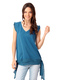
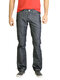
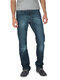
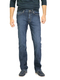
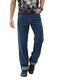
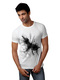
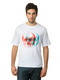
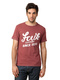
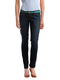
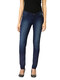
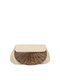
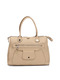

In [72]:
question = "dark blue french connection jeans for men"

hdense, hsparse = hybrid_scale(dense, sparse, alpha=0)
result = index.query(
    top_k=12,
    vector=hdense,
    sparse_vector=hsparse,
    include_metadata=True
)
imgs = [images[int(r["id"])] for r in result["matches"]]
display_result(imgs)

In [73]:
for x in result["matches"]:
    print(x["metadata"]['productDisplayName'])

French Connection Women Blue Top
Locomotive Men Washed Blue Jeans
Peter England Men Party Blue Jeans
Lee Men Blue Chicago Fit Jeans
Lee Men Blue Chicago Fit Jeans
French Connection Men White T-shirt
French Connection Men White T-shirt
French Connection Men Maroon T-shirt
Denizen Women Blue Jeans
Jealous 21 Women Washed Blue Jeans
French Connection Women Beige Clutch
French Connection Women Beige Handbag


# Using Mre Dense Or More Sparse


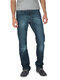
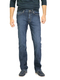
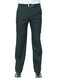
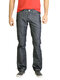
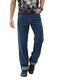
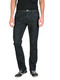
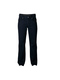
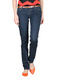
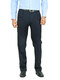
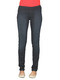
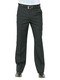
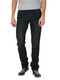

In [78]:
question = "dark blue french connection jeans for men"
#Closer to 0==more sparse, closer to 1==more dense
hdense, hsparse = hybrid_scale(dense, sparse, alpha=0.5)
result = index.query(
    top_k=12,
    vector=hdense,
    sparse_vector=hsparse,
    include_metadata=True
)
imgs = [images[int(r["id"])] for r in result["matches"]]
display_result(imgs)


In [79]:
for x in result["matches"]:
    print(x["metadata"]['productDisplayName'])
    

Peter England Men Party Blue Jeans
Lee Men Blue Chicago Fit Jeans
John Miller Men Reglur Black Trousers
Locomotive Men Washed Blue Jeans
Lee Men Blue Chicago Fit Jeans
Peter England Men Black Jeans
Gini and Jony Boys Solid Black Jeans
Tokyo Talkies Women Navy Slim Fit Jeans
Arrow Men Navy Blue Solid Trousers
Jealous 21 Women's Aaren Black Jegging
John Miller Men Solid Type Black Trousers
Peter England Men Party Black Jeans
